<a href="https://colab.research.google.com/github/Billy-code123/Fake-News-Detection-on-Reddit/blob/main/title_%2B_comments_%2B_engagement_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==4.30.2
!pip install tensorflow==2.12.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 615.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.

εκτελειται με τον ιδιο τροπο  οπως πριν (τιτλος και σχολια) για καλυτερη συγκριση αλλα με 20% dataset και

In [ ]:
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 97.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.2.2 which is incompatible.
tensorflow-text 2.17.0 requires tensorflow<2.18,>=2.17.0, but you have tensorflow 2.12.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.12.0 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18

In [ ]:
!pip install pandas numpy scikit-learn seaborn matplotlib lightgbm tensorflow transformers imbalanced-learn psutil

δοκιμη μοντελων με τιτλο, σχολια και upvote_ratio, score, number of comments

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack, csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from imblearn.over_sampling import RandomOverSampler

# **1. Preprocessing and Dataset Preparation**
# Combine Train and Validate datasets
df_combined = pd.concat([df_train, df_validate])

# Reduce dataset size to 20% while maintaining class distribution
df_reduced, _ = train_test_split(df_combined, test_size=0.8, stratify=df_combined['2_way_label'], random_state=42)

# Split reduced dataset into Train, Validate, and Test sets
df_train_new, df_temp = train_test_split(df_reduced, test_size=0.3, stratify=df_reduced['2_way_label'], random_state=42)
df_validate_new, df_test_new = train_test_split(df_temp, test_size=0.5, stratify=df_temp['2_way_label'], random_state=42)

# Aggregate comments by submission_id
df_comments_aggregated = df_comments.groupby('submission_id')['body'].apply(lambda x: ' '.join(x.dropna())).reset_index()

# Merge aggregated comments with Train, Validate, and Test datasets
df_train_combined = df_train_new.merge(df_comments_aggregated, left_on='id', right_on='submission_id', how='left')
df_validate_combined = df_validate_new.merge(df_comments_aggregated, left_on='id', right_on='submission_id', how='left')
df_test_combined = df_test_new.merge(df_comments_aggregated, left_on='id', right_on='submission_id', how='left')

# Combine title and comments into a single feature
df_train_combined['combined_text'] = df_train_combined['title'].fillna('') + " " + df_train_combined['body'].fillna('')
df_validate_combined['combined_text'] = df_validate_combined['title'].fillna('') + " " + df_validate_combined['body'].fillna('')
df_test_combined['combined_text'] = df_test_combined['title'].fillna('') + " " + df_test_combined['body'].fillna('')

# Define target variables
y_train = df_train_combined['2_way_label']
y_validate = df_validate_combined['2_way_label']
y_test = df_test_combined['2_way_label']

# **2. Feature Engineering**
# Dynamic TF-IDF vocabulary size
tfidf_vocab_size = min(5000, int(len(df_train_combined) * 0.1))

# TF-IDF Vectorization for combined text
tfidf = TfidfVectorizer(max_features=tfidf_vocab_size, stop_words='english')
X_train_text = tfidf.fit_transform(df_train_combined['combined_text'])
X_validate_text = tfidf.transform(df_validate_combined['combined_text'])
X_test_text = tfidf.transform(df_test_combined['combined_text'])

# Normalize numerical features
numeric_features = ['upvote_ratio', 'score', 'num_comments']
scaler = MinMaxScaler()
X_train_numeric = scaler.fit_transform(df_train_combined[numeric_features])
X_validate_numeric = scaler.transform(df_validate_combined[numeric_features])
X_test_numeric = scaler.transform(df_test_combined[numeric_features])

# Combine all features (exclude `subreddit` and `hasImage`)
X_train_combined = hstack([X_train_text, X_train_numeric])
X_validate_combined = hstack([X_validate_text, X_validate_numeric])
X_test_combined = hstack([X_test_text, X_test_numeric])

# Handle class imbalance using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_train_combined, y_train = oversampler.fit_resample(csr_matrix(X_train_combined), y_train)

# Convert to dense format for MLP
scaler_dense = StandardScaler(with_mean=False)
X_train_dense = scaler_dense.fit_transform(X_train_combined.toarray())
X_validate_dense = scaler_dense.transform(X_validate_combined.toarray())
X_test_dense = scaler_dense.transform(X_test_combined.toarray())

# **3. Model Training and Evaluation**
def run_experiment(model, X_train, y_train, X_validate, y_validate):
    model.fit(X_train, y_train)
    val_preds = model.predict(X_validate)
    val_accuracy = accuracy_score(y_validate, val_preds)
    return model, val_accuracy

def evaluate_model_with_kfold(model_func, X, y, k=5):
    """
    Perform k-fold cross-validation on the given model.
    """
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    X = csr_matrix(X)  # Ensure sparse matrix compatibility
    accuracies = []

    for train_idx, validate_idx in kfold.split(X, y):
        X_train, X_validate = X[train_idx], X[validate_idx]
        y_train, y_validate = y[train_idx], y[validate_idx]

        _, val_acc = model_func(X_train, y_train, X_validate, y_validate)
        accuracies.append(val_acc)

    return sum(accuracies) / len(accuracies)

# Evaluate models using k-fold cross-validation
results = {}

# Naive Bayes
nb_model = MultinomialNB()
results['Naive Bayes'] = evaluate_model_with_kfold(
    lambda X_train, y_train, X_validate, y_validate: run_experiment(nb_model, X_train, y_train, X_validate, y_validate),
    X_train_combined,
    y_train
)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
results['Logistic Regression'] = evaluate_model_with_kfold(
    lambda X_train, y_train, X_validate, y_validate: run_experiment(lr_model, X_train, y_train, X_validate, y_validate),
    X_train_combined,
    y_train
)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
results['Random Forest'] = evaluate_model_with_kfold(
    lambda X_train, y_train, X_validate, y_validate: run_experiment(rf_model, X_train, y_train, X_validate, y_validate),
    X_train_combined,
    y_train
)

# LightGBM
lgbm_model = LGBMClassifier(n_estimators=100, max_depth=10, random_state=42)
results['LightGBM'] = evaluate_model_with_kfold(
    lambda X_train, y_train, X_validate, y_validate: run_experiment(lgbm_model, X_train, y_train, X_validate, y_validate),
    X_train_combined,
    y_train
)

# MLP
def train_mlp(X_train, y_train, X_validate, y_validate):
    model = Sequential([
        Dense(256, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_validate, y_validate), verbose=1)
    val_loss, val_accuracy = model.evaluate(X_validate, y_validate, verbose=0)
    return model, val_accuracy

mlp_model, val_acc_mlp = train_mlp(X_train_dense, y_train, X_validate_dense, y_validate)
results['MLP'] = val_acc_mlp

# **4. Log Results**
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Validation Accuracy'])
print("\nValidation Results without Subreddit and HasImage Features:")
print(results_df)

# Save results to CSV
results_df.to_csv('validation_results_without_subreddit_hasImage.csv', index=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59146, number of negative: 59145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.229772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876405
[LightGBM] [Info] Number of data points in the train set: 118291, number of used features: 5003
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500004 -> initscore=0.000017
[LightGBM] [Info] Start training from score 0.000017


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59146, number of negative: 59145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.213504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 877713
[LightGBM] [Info] Number of data points in the train set: 118291, number of used features: 5003
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500004 -> initscore=0.000017
[LightGBM] [Info] Start training from score 0.000017


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59145, number of negative: 59146
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.223448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 880027
[LightGBM] [Info] Number of data points in the train set: 118291, number of used features: 5003
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499996 -> initscore=-0.000017
[LightGBM] [Info] Start training from score -0.000017


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59145, number of negative: 59146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.206861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876924
[LightGBM] [Info] Number of data points in the train set: 118291, number of used features: 5003
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499996 -> initscore=-0.000017
[LightGBM] [Info] Start training from score -0.000017


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59146, number of negative: 59146
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.198341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 881680
[LightGBM] [Info] Number of data points in the train set: 118292, number of used features: 5003
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 1/5
2311/2311 [==============================] - 18s 8ms/step - loss: 0.3276 - accuracy: 0.8528 - val_loss: 0.2796 - val_accuracy: 0.8772
Epoch 2/5
2311/2311 [==============================] - 17s 7ms/step - loss: 0.2303 - accuracy: 0.9043 - val_loss: 0.2750 - val_accuracy: 0.8794
Epoch 3/5
2311/2311 [==============================] - 17s 7ms/step - loss: 0.1709 - accuracy: 0.9321 - val_loss: 0.2825 - val_accuracy: 0.8851
Epoch 4/5
2311/2311 [==============================] - 17s 7ms/step - loss: 0.1235 - accuracy: 0.9527 - val_loss: 0.3275 - val_accuracy: 0.8838
Epoch 5/5
2311/2311 [==============================] - 16s 7ms/step - loss: 0.0941 - accuracy: 0.9652 - val_loss: 0.3771 - val_accuracy: 0.8823

Validation Results without Subreddit and HasImage Features:
                     Validation Accuracy
Naive Bayes                     0.773116
Logistic Regression             0.867033
Random Forest                   0.777059
LightGBM                        0.886294
MLP           

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
import tensorflow as tf
from sklearn.metrics import accuracy_score
import numpy as np

# **1. Preprocessing and Dataset Preparation**
# Combine Train and Validate datasets
df_combined = pd.concat([df_train, df_validate])

# Reduce dataset size to 20% while maintaining class distribution
df_reduced, _ = train_test_split(df_combined, test_size=0.8, stratify=df_combined['2_way_label'], random_state=42)

# Split reduced dataset into Train, Validate, and Test sets
df_train_new, df_temp = train_test_split(df_reduced, test_size=0.3, stratify=df_reduced['2_way_label'], random_state=42)
df_validate_new, df_test_new = train_test_split(df_temp, test_size=0.5, stratify=df_temp['2_way_label'], random_state=42)

# Aggregate comments by submission_id
df_comments_aggregated = df_comments.groupby('submission_id')['body'].apply(lambda x: ' '.join(x.dropna())).reset_index()

# Merge aggregated comments with Train and Validate datasets
df_train_combined = df_train_new.merge(df_comments_aggregated, left_on='id', right_on='submission_id', how='left')
df_validate_combined = df_validate_new.merge(df_comments_aggregated, left_on='id', right_on='submission_id', how='left')
# Fill missing comments with empty strings
df_train_combined['body'] = df_train_combined['body'].fillna('')
df_validate_combined['body'] = df_validate_combined['body'].fillna('')

# Combine title, comments, and metadata into a single feature
df_train_combined['combined_text'] = (
    df_train_combined['title'].fillna('') + " " +
    df_train_combined['body'] + " " +
    df_train_combined['upvote_ratio'].astype(str) + " " +
    df_train_combined['score'].astype(str) + " " +
    df_train_combined['num_comments'].astype(str)
)
df_validate_combined['combined_text'] = (
    df_validate_combined['title'].fillna('') + " " +
    df_validate_combined['body'] + " " +
    df_validate_combined['upvote_ratio'].astype(str) + " " +
    df_validate_combined['score'].astype(str) + " " +
    df_validate_combined['num_comments'].astype(str)
)

# Define target variables
y_train = df_train_combined['2_way_label']
y_validate = df_validate_combined['2_way_label']

# **2. Tokenization and Encoding for BiLSTM**
# BiLSTM Tokenization
max_len = 128
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_train_combined['combined_text'])

# Convert text to sequences and pad them
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(df_train_combined['combined_text']), maxlen=max_len)
X_validate_seq = pad_sequences(tokenizer.texts_to_sequences(df_validate_combined['combined_text']), maxlen=max_len)

# **3. BiLSTM Training Function**
def train_bilstm(X_train, y_train, X_validate, y_validate, vocab_size, max_len):
    # Build BiLSTM model
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train BiLSTM
    model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_validate, y_validate), verbose=1)

    # Validate Accuracy
    val_loss, val_accuracy = model.evaluate(X_validate, y_validate, verbose=0)
    return model, val_accuracy  # Return the trained model

# **4. Train BiLSTM and Assign to Global Variable**
bilstm_model, val_acc_bilstm = train_bilstm(X_train_seq, y_train, X_validate_seq, y_validate, vocab_size=vocab_size, max_len=max_len)

# **5. Save BiLSTM Model**
bilstm_model.save("bilstm_saved_model")

# **6. Results Logging**
results = []

# Log results for BiLSTM
results.append({'Model': 'BiLSTM', 'Validation Accuracy': val_acc_bilstm})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nValidation Results for BiLSTM:")
print(results_df)

# Save results to CSV
results_df.to_csv('validation_results_bilstm_with_metadata.csv', index=False)

Epoch 1/3
2124/2124 [==============================] - 203s 94ms/step - loss: 0.2836 - accuracy: 0.8694 - val_loss: 0.2375 - val_accuracy: 0.8949
Epoch 2/3
2124/2124 [==============================] - 199s 94ms/step - loss: 0.2237 - accuracy: 0.9012 - val_loss: 0.2231 - val_accuracy: 0.9011
Epoch 3/3
2124/2124 [==============================] - 199s 94ms/step - loss: 0.1946 - accuracy: 0.9165 - val_loss: 0.2305 - val_accuracy: 0.8988



Validation Results for BiLSTM:
    Model  Validation Accuracy
0  BiLSTM             0.898832


In [ ]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.models import load_model

#tinybert_model = TFBertForSequenceClassification.from_pretrained("tinybert_saved_model")
bilstm_model = load_model("bilstm_saved_model")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


910/910 [==============================] - 20s 21ms/step
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0          Naive Bayes  0.787466   0.899369  0.601115  0.720600  0.772375   
1  Logistic Regression  0.865556   0.860965  0.840928  0.850829  0.863562   
2        Random Forest  0.787191   0.879259  0.618137  0.725930  0.773501   
3             LightGBM  0.885302   0.845011  0.916547  0.879327  0.887833   
4                  MLP  0.882692   0.892775  0.844091  0.867751  0.879566   
5               BiLSTM  0.830460   0.750300  0.941478  0.835087  0.839451   

  Training Time (s)  Validation Time (s)  RAM Used (GB)  
0              None             0.024419      29.300240  
1              None             0.014006      29.300240  
2              None             0.412580      29.307850  
3              None             0.023867      29.312614  
4              None             2.753079      30.052971  
5              None            20.495498      29.996784

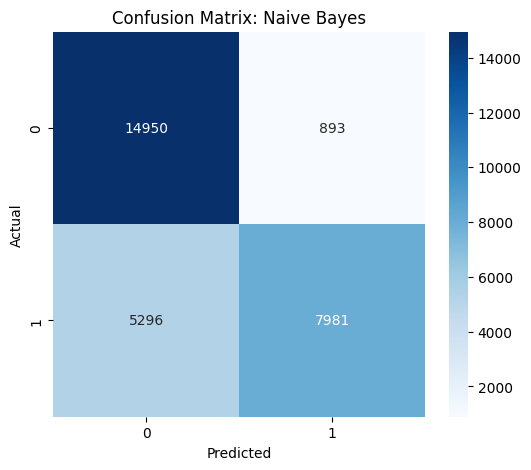

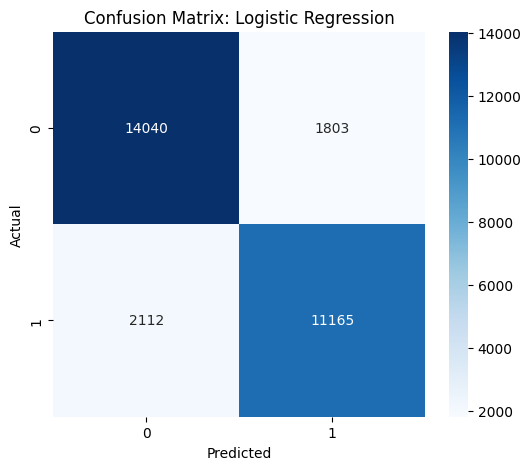

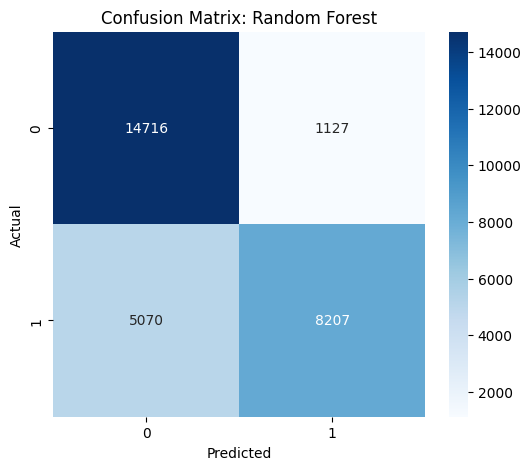

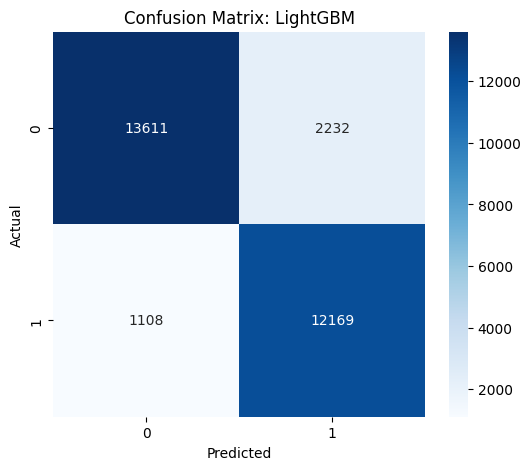

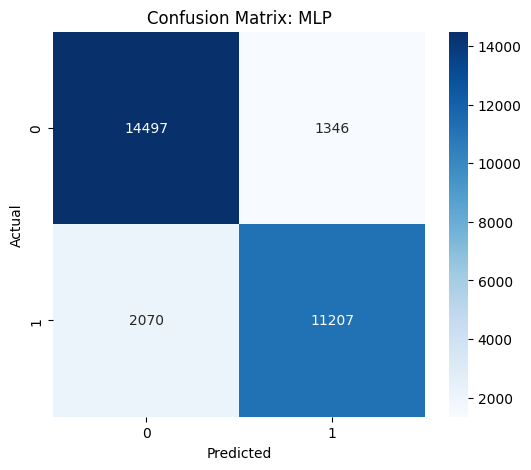

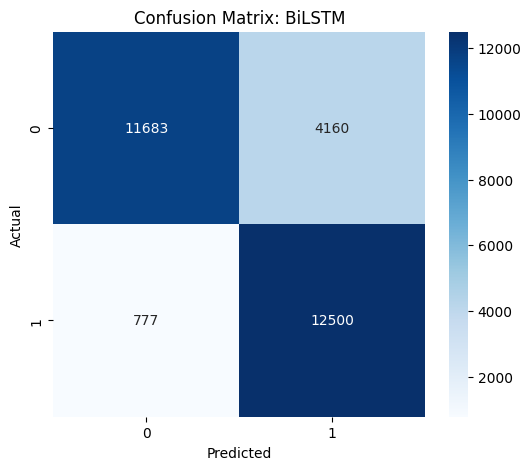

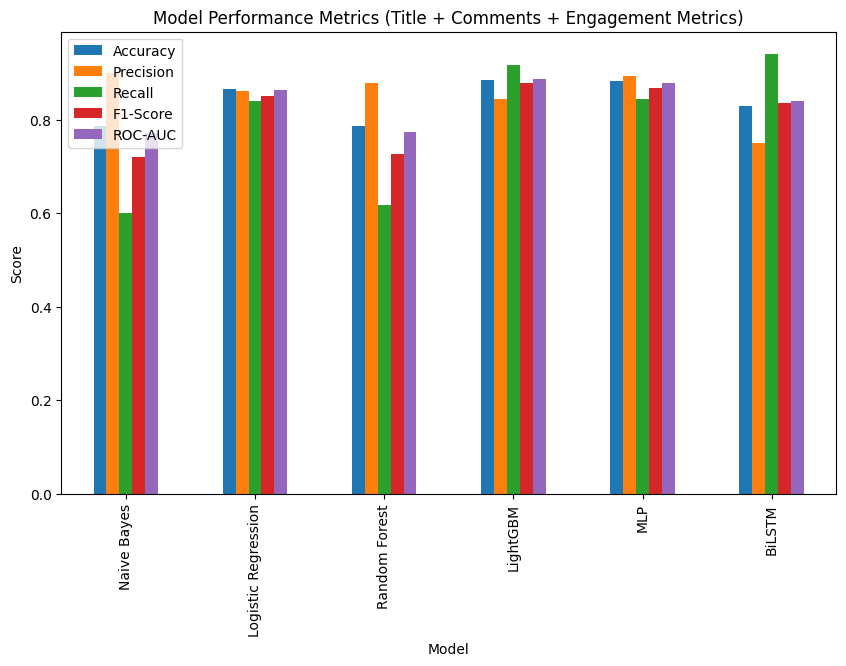

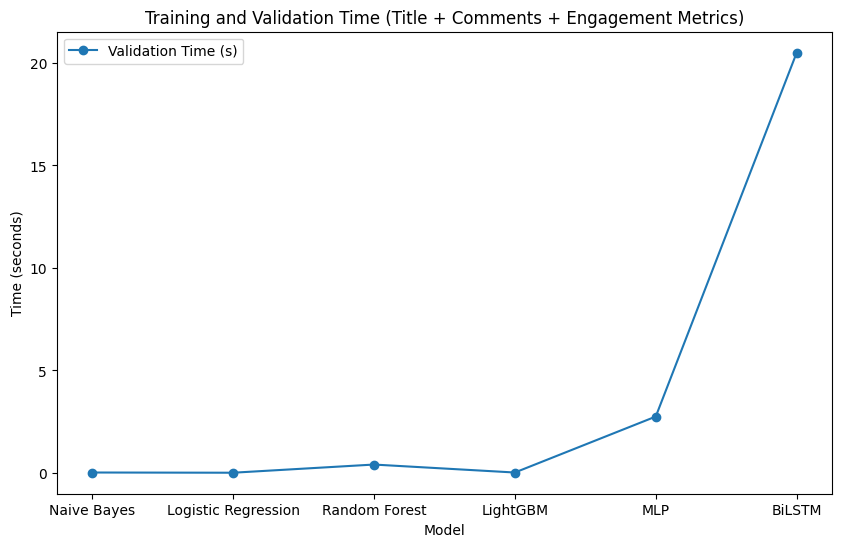

In [ ]:
# Save and reload the BiLSTM model (if needed)
bilstm_model.save("bilstm_saved_model")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import numpy as np
import pandas as pd
import time
import psutil
import tensorflow as tf

# Initialize storage for results
detailed_results = []
conf_matrices = {}

# Helper function to evaluate a model and collect results
def evaluate_model(model, X_test, y_test, model_name):
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()

    # Convert predictions for classifiers like TinyBERT & BiLSTM
    if isinstance(y_pred, np.ndarray) and y_pred.shape[-1] == 2:
        y_pred = np.argmax(y_pred, axis=1)
    else:
        y_pred = (y_pred > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred)
    conf_matrices[model_name] = confusion_matrix(y_test, y_pred)

    # Capture RAM usage
    ram_usage = psutil.Process().memory_info().rss / (1024 ** 3)  # Convert bytes to GB

    # Store detailed results
    detailed_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1-Score": report['1']['f1-score'],
        "ROC-AUC": roc_auc,
        "Training Time (s)": globals().get(f"train_time_{model_name.lower().replace(' ', '_')}", None),
        "Validation Time (s)": end_time - start_time,
        "RAM Used (GB)": ram_usage
    })

# Evaluate models for which test data is available
evaluate_model(nb_model, X_test_combined, y_test, "Naive Bayes")
evaluate_model(lr_model, X_test_combined, y_test, "Logistic Regression")
evaluate_model(rf_model, X_test_combined, y_test, "Random Forest")
evaluate_model(lgbm_model, X_test_combined, y_test, "LightGBM")
evaluate_model(mlp_model, X_test_dense, y_test, "MLP")

# Prepare test data for BiLSTM (if not already defined)
# Ensure df_test_combined exists and was prepared similarly to training data
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(df_test_combined['combined_text']), maxlen=max_len)
y_test = df_test_combined['2_way_label']

evaluate_model(bilstm_model, X_test_seq, y_test, "BiLSTM")

# Convert results to DataFrame
results_df = pd.DataFrame(detailed_results)
print(results_df)

# Save results to CSV
results_df.to_csv("final_model_results.csv", index=False)

# Plot Confusion Matrices
for model_name, conf_matrix in conf_matrices.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Bar Plot for Metrics
results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]].plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Metrics (Title + Comments + Engagement Metrics)")
plt.ylabel("Score")
plt.show()

# Line Plot for Training and Validation Time
results_df.set_index("Model")[["Training Time (s)", "Validation Time (s)"]].plot(kind="line", marker="o", figsize=(10, 6))
plt.title("Training and Validation Time (Title + Comments + Engagement Metrics)")
plt.ylabel("Time (seconds)")
plt.show()


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
import tensorflow as tf
from sklearn.metrics import accuracy_score
import numpy as np

# **1. Preprocessing and Dataset Preparation**
# Combine Train and Validate datasets
df_combined = pd.concat([df_train, df_validate])

# Reduce dataset size to 20% while maintaining class distribution
df_reduced, _ = train_test_split(df_combined, test_size=0.8, stratify=df_combined['2_way_label'], random_state=42)

# Split reduced dataset into Train, Validate, and Test sets
df_train_new, df_temp = train_test_split(df_reduced, test_size=0.3, stratify=df_reduced['2_way_label'], random_state=42)
df_validate_new, df_test_new = train_test_split(df_temp, test_size=0.5, stratify=df_temp['2_way_label'], random_state=42)

# Aggregate comments by submission_id
df_comments_aggregated = df_comments.groupby('submission_id')['body'].apply(lambda x: ' '.join(x.dropna())).reset_index()

# Merge aggregated comments with Train and Validate datasets
df_train_combined = df_train_new.merge(df_comments_aggregated, left_on='id', right_on='submission_id', how='left')
df_validate_combined = df_validate_new.merge(df_comments_aggregated, left_on='id', right_on='submission_id', how='left')

# Fill missing comments with empty strings
df_train_combined['body'] = df_train_combined['body'].fillna('')
df_validate_combined['body'] = df_validate_combined['body'].fillna('')

# Combine title, comments, and metadata into a single feature
df_train_combined['combined_text'] = (
    df_train_combined['title'].fillna('') + " " +
    df_train_combined['body'] + " " +
    df_train_combined['upvote_ratio'].astype(str) + " " +
    df_train_combined['score'].astype(str) + " " +
    df_train_combined['num_comments'].astype(str)
)
df_validate_combined['combined_text'] = (
    df_validate_combined['title'].fillna('') + " " +
    df_validate_combined['body'] + " " +
    df_validate_combined['upvote_ratio'].astype(str) + " " +
    df_validate_combined['score'].astype(str) + " " +
    df_validate_combined['num_comments'].astype(str)
)

# Define target variables
y_train = df_train_combined['2_way_label']
y_validate = df_validate_combined['2_way_label']

# **2. Tokenization and Encoding for Models**
# TinyBERT Tokenization
tinybert_tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-4_H-512_A-8')
train_encodings = tinybert_tokenizer(
    list(df_train_combined['combined_text']), truncation=True, padding=True, max_length=128, return_tensors="tf"
)
validate_encodings = tinybert_tokenizer(
    list(df_validate_combined['combined_text']), truncation=True, padding=True, max_length=128, return_tensors="tf"
)

# BiLSTM Tokenization
max_len = 128
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_train_combined['combined_text'])

# Convert text to sequences and pad them
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(df_train_combined['combined_text']), maxlen=max_len)
X_validate_seq = pad_sequences(tokenizer.texts_to_sequences(df_validate_combined['combined_text']), maxlen=max_len)

# **3. Model Definitions and Training**
# TinyBERT Training Function
def train_tinybert(train_encodings, y_train, validate_encodings, y_validate):
    # Debugging shapes to ensure consistency
    print(f"Train Encodings: {train_encodings['input_ids'].shape}")
    print(f"y_train: {y_train.shape}")
    print(f"Validate Encodings: {validate_encodings['input_ids'].shape}")
    print(f"y_validate: {y_validate.shape}")

    # Convert labels to TensorFlow tensors
    y_train = tf.convert_to_tensor(y_train.values, dtype=tf.int32)
    y_validate = tf.convert_to_tensor(y_validate.values, dtype=tf.int32)

    # Prepare Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).batch(16)
    validate_dataset = tf.data.Dataset.from_tensor_slices((dict(validate_encodings), y_validate)).batch(16)

    # Load and compile TinyBERT model
    tinybert_model = TFBertForSequenceClassification.from_pretrained(
        'google/bert_uncased_L-4_H-512_A-8',
        num_labels=2,
        from_pt=True
    )
    optimizer = Adam(learning_rate=5e-5)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    tinybert_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # Train TinyBERT
    print("Starting TinyBERT training...")
    tinybert_model.fit(train_dataset, validation_data=validate_dataset, epochs=3)

    # Validate Accuracy
    val_loss, val_accuracy = tinybert_model.evaluate(validate_dataset)
    return tinybert_model, val_accuracy

# BiLSTM Training Function
def train_bilstm(X_train, y_train, X_validate, y_validate, vocab_size, max_len):
    # Build BiLSTM model
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train BiLSTM
    model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_validate, y_validate), verbose=1)

    # Validate Accuracy
    val_loss, val_accuracy = model.evaluate(X_validate, y_validate, verbose=0)
    return model, val_accuracy

# **4. Results Logging**
results = []

# Train and evaluate TinyBERT
_, val_acc_tinybert = train_tinybert(train_encodings, y_train, validate_encodings, y_validate)
results.append({'Model': 'TinyBERT', 'Validation Accuracy': val_acc_tinybert})

# Train and evaluate BiLSTM
_, val_acc_bilstm = train_bilstm(X_train_seq, y_train, X_validate_seq, y_validate, vocab_size=vocab_size, max_len=max_len)
results.append({'Model': 'BiLSTM', 'Validation Accuracy': val_acc_bilstm})

# Log results
results_df = pd.DataFrame(results)
print("\nValidation Results for TinyBERT and BiLSTM:")
print(results_df)

# Save results to CSV
results_df.to_csv('validation_results_tinybert_bilstm_with_metadata.csv', index=False)
